# Redes Sociais - APS 3

### Alunos: Arthur Barreto, Enricco Gemha e Felipe Catapano


Extraindo dados do *The Movies Dataset* [$^1$](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset), construímos uma rede de atores/atrizes em Hollywood que se conectam quando participam do mesmo filme como atores/atrizes, considerando mais de 45.000 filmes. Os vértices representam atores/atrizes em Hollywood e uma aresta não-direcionada indica um filme em que ambos atores/atrizes participaram.

## Pré-requisitos

In [1]:
import graph_tool_extras as gte
import netpixi
from graph_tool import draw
import distribution as dst
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
PATH = 'credits.csv'

## Análise dos dados importados

O arquivo que contém os dados necessários para que possamos montar a rede é `credits.csv`, que representa uma lista de valores separados por _vírgulas_. O significado de cada coluna do arquivo é:

- Primeira coluna: Elenco de um filme, ou seja, informações relacionadas aos atores (esta é a qual estamos interessados)
- Segunda coluna: Equipe de produção do filme
- Terceira coluna: ID do filme

In [3]:
def get_data(line):
    error_count = 0
    # Adquire somente a primeira coluna (cast)
    casting = (line.split('","')[0])[1:]
    # Retira os colchetes
    casting = casting.replace('[', '').replace(']', '')
    # Adquire os dados
    casting = casting.replace('{', '').split('},')
    # insere os nomes dos atores em uma lista
    movie_actor_list = []
    for cast in casting:
        try:
            actor_id = int(cast.split("'id': ")[1].split(",")[0])
            movie_actor_list.append(actor_id)
        except:
            error_count += 1
    
    # Retorna uma lista contendo os nomes dos atores
    return movie_actor_list, error_count



all_movies = []
with open(PATH) as f:
    i = 0
    error_count = 0
    next(f)
    for line in f:
        actor_list, new_error_count = get_data(line)
        error_count += new_error_count
        all_movies.append(actor_list)
        i += 1
        
print(f'Foram lidos {i-error_count} filmes.')
print(f'Foram encontrados {error_count} erros.')

Foram lidos 45055 filmes.
Foram encontrados 421 erros.


## Analisando o dataset

Primeiro, criaremos um dicionário de pares únicos de atores que trabalharam juntos em um filme, com seus IDs e quantas vezes já trabalharam juntos, a partir das informações já lidas. Isso será essencial para a construção da rede.

In [4]:
collaborations = {}

for movie in all_movies:
    for i in range(len(movie)):
        for j in range(i+1, len(movie)):
            actor1 = movie[i]
            actor2 = movie[j]
            if actor1 != actor2:
                if actor1 > actor2:
                    actor1, actor2 = actor2, actor1
                if (actor1, actor2) in collaborations:
                    collaborations[(actor1, actor2)] += 1
                else:
                    collaborations[(actor1, actor2)] = 1

print(f'Foram encontradas {len(collaborations)} colaborações.')
print(f'Primeiras 20 colaborações: {list(collaborations.items())[0:20]}')

Foram encontradas 6195247 colaborações.
Primeiras 20 colaborações: [((31, 12898), 10), ((31, 7167), 8), ((31, 12899), 2), ((31, 12900), 8), ((31, 7907), 7), ((31, 8873), 3), ((31, 1116442), 3), ((31, 12901), 2), ((31, 12133), 3), ((31, 8655), 3), ((31, 12903), 1), ((31, 37221), 1), ((7167, 12898), 8), ((12898, 12899), 2), ((12898, 12900), 8), ((7907, 12898), 7), ((8873, 12898), 2), ((12898, 1116442), 3), ((12898, 12901), 2), ((12133, 12898), 3)]


Em seguida, traçaremos um histograma onde o eixo x é o número de colaborações e o eixo y é o número de pares de atores que colaboraram tantas vezes. Isso nos dará uma ideia de como a rede é distribuída.

35


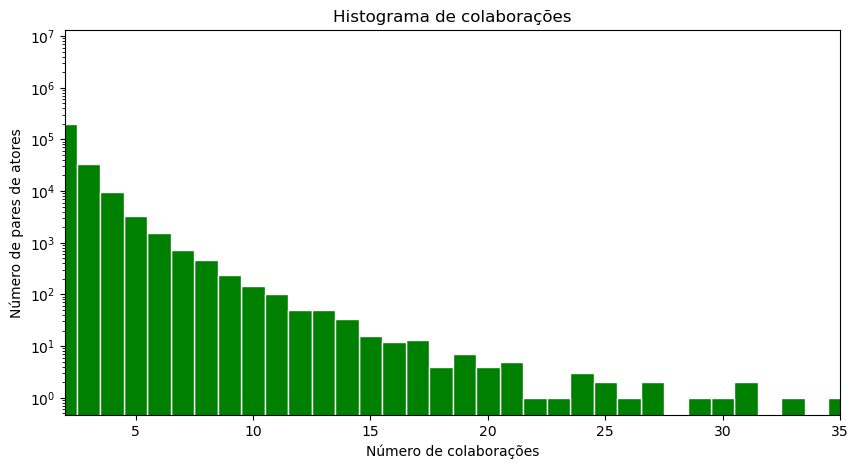

In [5]:
collaborations_histogram = {}

for pair, count in collaborations.items():
    if count in collaborations_histogram:
        collaborations_histogram[count] += 1
    else:
        collaborations_histogram[count] = 1

plt.figure(figsize=(10, 5))
plt.bar(collaborations_histogram.keys(), collaborations_histogram.values(), width=1, color='g', log=True, edgecolor='white')
x_min = min(list(collaborations_histogram.keys()))
x_max = max(list(collaborations_histogram.keys()))
print(x_max)
plt.xlim(2, x_max)
plt.xlabel('Número de colaborações')
plt.ylabel('Número de pares de atores')
plt.title('Histograma de colaborações')
plt.show()

In [6]:
soma = sum(list(collaborations_histogram.values()))
chaves = list(collaborations_histogram.keys())
chaves.sort()
for i in chaves:
    print(f'{i} ou mais collabs: {soma}')
    try:
        soma -= collaborations_histogram[i]
    except:
        pass

1 ou mais collabs: 6195247
2 ou mais collabs: 251705
3 ou mais collabs: 48887
4 ou mais collabs: 16192
5 ou mais collabs: 6760
6 ou mais collabs: 3416
7 ou mais collabs: 1900
8 ou mais collabs: 1164
9 ou mais collabs: 693
10 ou mais collabs: 454
11 ou mais collabs: 310
12 ou mais collabs: 210
13 ou mais collabs: 161
14 ou mais collabs: 111
15 ou mais collabs: 77
16 ou mais collabs: 61
17 ou mais collabs: 49
18 ou mais collabs: 36
19 ou mais collabs: 32
20 ou mais collabs: 25
21 ou mais collabs: 21
22 ou mais collabs: 16
23 ou mais collabs: 15
24 ou mais collabs: 14
25 ou mais collabs: 11
26 ou mais collabs: 9
27 ou mais collabs: 8
29 ou mais collabs: 6
30 ou mais collabs: 5
31 ou mais collabs: 4
33 ou mais collabs: 2
35 ou mais collabs: 1


**Arestas com peso**

Cada aresta representa a quantidade de filmes que os atores participaram juntos. Portanto, quanto maior o número de filmes em comum, mais peso a aresta terá, ou seja, maior significância ela terá.

**Análise por moda**

Em situações como esta, quando temos aresta com pesos, uma alternativa possível é eliminar o número que mais se repete, ou seja, a moda. Portanto, o nosso corte será na aresta com o valor mais comum de colaborações entre atores, ou seja, o valor da moda.

In [7]:
# Imprime a quantidade de colaborações com mais arestas (moda)
moda = max(collaborations_histogram.values())
moda = [k for k, v in collaborations_histogram.items() if v == moda]
print(f'A moda é {moda[0]} colaboração.')

A moda é 1 colaboração.


## Criação do grafo

Utilizaremos a biblioteca [graph-tool](https://graph-tool.skewed.de/) somente para criação e visualização básica dos grafos, sem suporte de nenhum método ou função que não seja essencial.

In [8]:
g = gte.Graph(directed=False) # pois o grafo é não direcionado

Antes, vamos definir duas funções auxiliares para facilitar a adição de novos nós e arestas, respectivamente.

In [9]:
def get_or_add_vertex(g, id):
    u = g.vertex_by_id(id)
    if u is None:
        u = g.add_vertex_by_id(id)
    return u

In [10]:
def get_or_add_edge(g, id1, id2):
    e = g.edge_by_ids(id1, id2)
    if e is None:
        e = g.add_edge_by_ids(id1, id2)
    return e

Agora sim, vamos popular o grafo com os dados que temos.

Para cada uma das colaborações armazenada no dicionário collaborations criado acima, cria-se os vértices e as arestas correspondentes no grafo caso os atores tenham trabalhado juntos em ao menos dois filmes.

In [11]:
i = 0
for colaboracao in list(collaborations.items()):
    
    #Indices dos nós
    no1 = colaboracao[0][0]
    no2 = colaboracao[0][1]

    #Quantidade de filmes juntos
    quantidade_filmes_juntos = colaboracao[1]

    #Cria os nós e uma aresta entre eles caso passe no limiar definido
    if quantidade_filmes_juntos >= 2:
        get_or_add_vertex(g, no1)
        get_or_add_vertex(g, no2)
        get_or_add_edge(g, no1, no2)
        i += 1

print(f"Foram considerados {i} pares únicos")

Foram considerados 251705 pares únicos


A seguir, devemos chamar `draw.sfdp_layout`, passando a rede, para rodar um algoritmo de posicionamento chamado SFDP [[1](#sfdp)].

Esse algoritmo usa uma ideia conhecida como [force-directed graph drawing](https://en.wikipedia.org/wiki/Force-directed_graph_drawing) para posicionar os vértices de forma a evidenciar agrupamentos.

Também utilizamos o método clean para garantir que não há nós isolados na rede, que não são interessantes para a análise.

In [12]:
layout = draw.sfdp_layout(g)

In [13]:
g = gte.clean(g)
gte.move(g, layout)

## Armazenamento da rede

Para garantir a segurança da informação processada, devemos guardá-la em um arquivo na mesma pasta deste notebook.

In [14]:
gte.save(g, 'actors.net.gz')

## Visualização da rede

O próximo passo é a renderização da rede.

In [15]:
r = netpixi.render('actors.net.gz', infinite=True)

Por fim, devemos ajustar a visualização da renderização.

In [16]:
r.vertex_default(size=4, bwidth=1)

In [17]:
r.edge_default(width=1)

## Estatísticas

Agora, devemos ver o tamanho da rede, ou seja, a quantidade de _vertices_ (vértices) e _edges_ (arestas).

In [18]:
print(f"Número de vértices: {len(g.get_vertices())}")
print(f"Número de arestas: {len(g.get_edges())}")

Número de vértices: 45550
Número de arestas: 246755


Afim de compreender melhor a rede, devemos obter os valores de **densidade** e **transitividade** da rede.

A densidade da rede é a razão entre número de pares conectados, dentre todos os pares.

Por outro lado, a transitividade aponta a razão de trios de nós que estão conectados, dentre todos os trios, na forma de triângulos.

In [19]:
print(f"Densidade da rede: {g.density()}")
print(f"Transitividade da rede: {g.transitivity()}")

Densidade da rede: 0.023786
Transitividade da rede: 19.886067


Buscamos obter em seguida uma `Series` (_type_ do Pandas), em que cada vértice possui um valor para o número de vizinhos que possui. 

Em seguida usamos o método describe para obter algumas estatísticas descritivas sobre a distribuição de graus dos vértices. Também plotamos um histograma para visualizar a distribuição de graus.

In [20]:
degrees = g.get_total_degrees()

In [21]:
degrees.describe()

count    45550.000000
mean        10.834468
std         25.831617
min          1.000000
25%          1.000000
50%          3.000000
75%         10.000000
max       1181.000000
dtype: float64

In [ ]:
degrees.hist(bins = int(np.sqrt(len(g.get_edges() ) ) ) );

### Power law

Vamos verificar se a distribuição de degree é normal ou se segue uma power law. Para isso chamamos as funções not_normal para verificar o p-value de uma normalidade, more_powerlaw_than_lognormal para verificar se a distribuição é mais parecida com uma power law do que com uma lognormal e more_powerlaw_than_exponential para verificar se a distribuição é mais parecida com uma power law do que com uma exponencial.

In [ ]:
dst.not_normal(degrees)

In [ ]:
dst.more_powerlaw_than_lognormal(degrees)

In [ ]:
dst.more_powerlaw_than_exponential(degrees)

Com isso podemos concluir que a distribuição é, de fato, uma power law.

### Obtendo a Distribuição de Distância

Com os novos métodos describe_distances e get_distances utilizados na disciplina, podemos obter a distribuição de distância da rede sem a necessidade de estratégias de amostragem (pois não armazena as distâncias na memória).

In [ ]:
g.describe_distances()

In [ ]:
g.hist_distances()